In [1]:
import torch
import onnx
import tensorrt # python3 -m pip install --upgrade tensorrt

/home/wonguk/anaconda3/envs/onnx/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys,os
sys.path.append("..")
from models.utils import UNet

In [3]:
model = UNet().to('cuda')
#load weight
model.load_state_dict(torch.load('/home/wonguk/coding/paper_project/hojun/light_weight/wieghts/ckpt_290.pt'))

<All keys matched successfully>

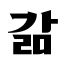

In [4]:
from PIL import Image

img = Image.open("/home/wonguk/coding/paper_project/hojun/data/62570_갊.png")
img

In [5]:
import torchvision
transforms = torchvision.transforms.Compose([
        # torchvision.transforms.Resize((input_size,input_size)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
img = transforms(img)
img.shape


torch.Size([1, 64, 64])

In [6]:
img_batch = torch.unsqueeze(img,0)
img_batch = img_batch.repeat(8,1,1,1).to('cuda')
img_batch.shape


torch.Size([8, 1, 64, 64])

In [9]:
# t : torch.Size([8])
# char : torch.Size([8, 296])
img_batch = torch.randn([1,1,64,64]).to('cuda')
t = torch.randn([1]).to('cuda')
char = torch.randn([1,296]).to('cuda')


In [10]:
# convert pytorch to onnx
onnx_filename = "onnx_model.onnx"
input_names = ["x", "t", "char"]
output_names = ["output"]

torch.onnx.export(model,
                  (img_batch,t,char),
                  onnx_filename,
                  export_params = True,
                  opset_version = 14, # pytorch 버전 이슈 발생 -> conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia // python  3.10.13
                  do_constant_folding = True,
                  input_names = input_names,
                  output_names = output_names,
                  dynamic_axes = {'x' : {0 : 'batch_size'},
                                  't' : {0 : 'batch_size'},
                                  'char' : {0 : 'batch_size'}
                                })

# torch.onnx.export(model,
#                   (img_batch,t,char),
#                   onnx_filename,
#                   export_params = True,
#                   opset_version = 14, # pytorch 버전 이슈 발생 -> conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia // python  3.10.13
#                   do_constant_folding = True,
#                   input_names = input_names,
#                   output_names = output_names,
#                   dynamic_axes = {'x' : {0 : 'batch_size'},
#                                   't' : {0 : 'batch_size'},
#                                   'char' : {0 : 'batch_size'},
#                                 'output' : {0 : 'batch_size'}})

/home/wonguk/anaconda3/envs/onnx/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/wonguk/anaconda3/envs/onnx/lib/python3.8/site-packages/torch/onnx/utils.py:687: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/home/wonguk/anaconda3/envs/onnx/lib/python3.8/site-packag

In [8]:
import onnxruntime as ort

# ONNX 모델 불러오기
onnx_model = onnx.load('/home/wonguk/coding/paper_project/hojun/light_weight/onnx_model.onnx')
ort_session = ort.InferenceSession('/home/wonguk/coding/paper_project/hojun/light_weight/onnx_model.onnx')


In [13]:
print(img_batch.shape)
print(t.shape)
print(char.shape)
print(char.type)

torch.Size([8, 1, 64, 64])
torch.Size([8])
torch.Size([8, 296])
<built-in method type of Tensor object at 0x7f36c2291b80>


In [18]:

input_data = {
    "x" : img_batch.cpu().numpy(),
    "t" : t.cpu().numpy(),
    "char" : char.cpu().numpy()
}
output = ort_session.run(None, input_data)
print(output)

[array([[[[-0.10639653,  0.04439037,  0.10102789, ...,  0.12326263,
          -0.02602465, -0.16364805],
         [ 0.07116662, -0.05104019, -0.15301642, ..., -0.09398307,
          -0.03608431, -0.03658168],
         [ 0.12347434, -0.08546165, -0.14521451, ..., -0.09615244,
          -0.08789815, -0.05091392],
         ...,
         [ 0.13512728, -0.04711135, -0.14415167, ..., -0.0985157 ,
          -0.09971239, -0.03730395],
         [ 0.18343157, -0.01006906, -0.14700025, ..., -0.1208332 ,
          -0.07512759, -0.13458695],
         [ 0.03641973,  0.02900542, -0.03871416, ..., -0.03445272,
          -0.13498864, -0.35216713]]],


       [[[-0.17673534,  0.19001903,  0.26843455, ...,  0.29452294,
           0.1588127 ,  0.16982128],
         [ 0.07772186,  0.02625325, -0.03114012, ..., -0.03193667,
           0.0700267 ,  0.11363234],
         [ 0.265553  ,  0.04567422,  0.06596021, ...,  0.06332278,
           0.10093769,  0.19272122],
         ...,
         [ 0.30636713,  0.04473

In [19]:
from onnx.tools import graph

# onnx graph 추출
graph_def = onnx_model.graph

# 그래프 시각화
graph.plot_graph(graph_def, node_names = True) # 이유는 모르지만 시각화가 안됨

# 

ImportError: cannot import name 'graph' from 'onnx.tools' (/home/wonguk/anaconda3/envs/onnx/lib/python3.8/site-packages/onnx/tools/__init__.py)

In [1]:
import tensorrt.BuilderFlag


['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'build_engine',
 'build_serialized_network',
 'create_builder_config',
 'create_network',
 'create_optimization_profile',
 'error_recorder',
 'gpu_allocator',
 'is_network_supported',
 'logger',
 'max_DLA_batch_size',
 'max_batch_size',
 'max_threads',
 'num_DLA_cores',
 'platform_has_fast_fp16',
 'platform_has_fast_int8',
 'platform_has_tf32',
 'reset']

In [6]:
import tensorrt 
 
onnx_file_name = '/home/wonguk/coding/paper_project/hojun/light_weight/onnx_model.onnx'
tensorrt_file_name = 'tensorrt.plan'
fp_16_mode = True
TRT_LOGGER = tensorrt.Logger(tensorrt.Logger.WARNING)
EXPLICIT_BATCH = 1 << (int)(tensorrt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
 
builder = tensorrt.Builder(TRT_LOGGER)
network = builder.create_network(EXPLICIT_BATCH)
parser = tensorrt.OnnxParser(network, TRT_LOGGER)
builder_config = builder.create_builder_config()
# builder_config.max_workspace_size = (1<<30)
# builder_config.set_memory_pool_limit =(1<<30)
# builder.fp16_mode = fp16_mode
 
with open(onnx_file_name, 'rb') as model:
    if not parser.parse(model.read()):
        for error in range(parser.num_errors):
            print (parser.get_error(error))
 
engine = builder.build_engine(network=network,config=builder_config)
buf = engine.serialize()
with open(tensorrt_file_name, 'wb') as f:
    f.write(buf)

/tmp/ipykernel_35085/1737570757.py:22: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network=network,config=builder_config)


[10/05/2023-01:10:24] [TRT] [W] TensorRT was linked against cuDNN 8.4.1 but loaded cuDNN 8.4.0
[10/05/2023-01:10:45] [TRT] [W] TensorRT was linked against cuDNN 8.4.1 but loaded cuDNN 8.4.0
[10/05/2023-01:10:45] [TRT] [W] The getMaxBatchSize() function should not be used with an engine built from a network created with NetworkDefinitionCreationFlag::kEXPLICIT_BATCH flag. This function will always return 1.
[10/05/2023-01:10:45] [TRT] [W] The getMaxBatchSize() function should not be used with an engine built from a network created with NetworkDefinitionCreationFlag::kEXPLICIT_BATCH flag. This function will always return 1.


In [ ]:
import os
import random
import wandb
import torch, torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from PIL import Image

from matplotlib import pyplot as plt
from modules.diffusion import Diffusion
from modules.utils import plot_images, test_save_images,make_stroke,stroke_to_char
from models.utils import UNet
from modules.utils import CharAttar
batch_size = 8 #####
sampleImage_len = 36


num_classes = 420
input_length = 100
contents_dim = 100
input_size = 64
mode = "new"
folder_name ="test_3"

train_dirs = '/home/wonguk/coding/paper_project/hojun/data/Hangul_Characters_Image64_radomSampling420_GrayScale'
sample_img_path = '/home/wonguk/coding/paper_project/hojun/data/62570_갊.png'

if __name__ == '__main__':
    wandb.init(project="onnx_sampling", config={
                "learning_rate": 0.0003,
                "architecture": "UNET",
                "dataset": "HOJUN_KOREAN_FONT64",
                "notes":"content, yes_stoke, non_style/ 64 x 64, 420 dataset"
                },
            name = "self-attetnion onnx_sampling 나눔손글씨강인한위로_갊") #####
    os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # model = UNet().to(device)
    # ckpt = torch.load("/home/hojun/Documents/code/Kofont5/KoFont-Diffusion2/hojun/results/models/font_noStrokeStyle_Unet64_image420_3/ckpt_290.pt")
    # model.load_state_dict(ckpt)

    diffusion = Diffusion(first_beta=1e-4,
                              end_beta=0.02,
                              noise_step=1000,
                              beta_schedule_type='linear',
                              img_size=input_size,
                              device=device)
    
    transforms = torchvision.transforms.Compose([
        # torchvision.transforms.Resize((input_size,input_size)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
    dataset = torchvision.datasets.ImageFolder(train_dirs,transform=transforms)

    # test set
    n = range(0,len(dataset),100)
    dataset = Subset(dataset, n)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers=12)

    #sample_img
    sample_img = Image.open(sample_img_path)
    sample_img = transforms(sample_img).to(device)
    sample_img = torch.unsqueeze(sample_img,1)
    sample_img = sample_img.repeat(sampleImage_len, 1, 1, 1)
    
    if mode == "random":
        contents_emb = torch.zeros(input_length,contents_dim)

        first= [random.randint(0,18) for _ in range(input_length)]
        middle = [random.randint(19,39) for _ in range(input_length)]
        last = [random.randint(40,67) for _ in range(input_length)]

        strokes = torch.Tensor([[0 for _ in range(68)] for _ in range(input_length)])

        for idx in range(input_length):
            strokes[idx][first[idx]], strokes[idx][middle[idx]], strokes[idx][last[idx]] = 1, 1, 1
        char_list = stroke_to_char(strokes)

        style_emb = torch.zeros(input_length,12288)

        y = torch.cat([contents_emb, strokes, style_emb], dim=1).to(device)
        x = diffusion.test_sampling(model, input_length, y, cfg_scale=3)

    elif mode == "manual":
        char_list = ['가,나,다,라,마,바,사,아,자,차,카,타,파,하']
        contents_emb = torch.zeros(input_length, contents_dim)
        strokes = make_stroke(char_list)
        style_emb = torch.zeros(input_length, 12288)
        y = torch.cat([contents_emb, strokes, style_emb], dim=1).to(device)
        x = diffusion.test_sampling(model,len(strokes), y, cfg_scale=3)
        
    elif mode == "new":
        charAttar = CharAttar(num_classes=num_classes,device=device)
        sampled_images = diffusion.portion_sampling(model, n=len(dataset.dataset.classes),sampleImage_len = sampleImage_len,dataset=dataset,mode =mode,charAttar=charAttar,sample_img=sample_img)